In [14]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
import gym

In [21]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average of rewards")
    plt.xlabel("Simulation time")
    plt.ylabel("Score")
    plt.show()

In [22]:
model=nengo.Network()

env = gym.make('CartPole-v0').env

class EnvironmentInterface(object):
    def __init__(self,env,stepSize =5):
        self.env = env
        self.n_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.t=0
        self.stepsize = stepSize
        self.output = np.zeros(self.n_actions)
        self.state = env.reset()
        self.reward= 0
        self.current_action = 0
        self.reward_arr = []
        self.totalReward = 0

    def take_action(self,action):
        self.state,self.reward,self.done,_=env.step(action)
        self.totalReward += self.reward
        if self.done:
            self.reward = -2
            self.totalReward += self.reward
            self.reward_arr.append(self.totalReward)
            self.state = env.reset()
            self.totalReward = 0

    def get_reward(self,t):
        return self.reward
    
    def sensor(self,t):
        return self.state

    
    def step(self,t,x):
        if int(t*1000)%self.stepsize == 0:
            self.current_action = np.argmax(x) #np.argmax(self.output)#
            self.take_action(self.current_action)
    
    def calculate_Q(self,t,x):

        if int(t*1000) % self.stepsize == 1:
            qmax = x[np.argmax(x)]
            self.output = x
            self.output[self.current_action] = 0.9*qmax + self.reward
            
        return self.output
    
        

In [23]:
tau = 0.01

fast_tau = 0
slow_tau = 0.01
n_action =2
envI=EnvironmentInterface(env)

state_dimensions=envI.state_dim
n_actions = envI.n_actions


from gym import wrappers
from datetime import datetime
#Video Capturing Mechanism 
filename="test"
is_monitor=False
# env.close()
if is_monitor:
    #filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)
    env.reset()




In [24]:
with model:
    sensor = nengo.Node(envI.sensor)
    reward = nengo.Node(envI.get_reward)
    
    sensor_net = nengo.Ensemble(n_neurons=1000,dimensions=envI.state_dim,radius=10)
    
    nengo.Connection(sensor,sensor_net)
    
    action_net = nengo.Ensemble(n_neurons=1000,dimensions=envI.n_actions,radius=10)
    
    learning_conn=nengo.Connection(sensor_net,action_net,function=lambda x:[0,0],learning_rule_type=nengo.PES(1e-3, pre_tau=slow_tau),synapse=tau)
   
    q_node = nengo.Node(envI.calculate_Q,size_in=2,size_out=2)
    
    step_node = nengo.Node(envI.step,size_in=2)
    
    nengo.Connection(action_net,step_node,synapse=fast_tau)
    
    nengo.Connection(action_net,q_node,synapse=tau)
    
    
    nengo.Connection(q_node,learning_conn.learning_rule,transform =-1,synapse=fast_tau) ##0.9*Q(s',a')+r
    
    nengo.Connection(action_net,learning_conn.learning_rule,transform =1,synapse=slow_tau)#Q(s,a)




In [25]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'agent_model.py.cfg')

/home/lsr/anaconda3/lib/python3.6/site-packages/nengo_gui/ipython.py:63: ConfigReuseWarning: Reusing config. Only the most recent visualization will update the config.
  "Reusing config. Only the most recent visualization will "


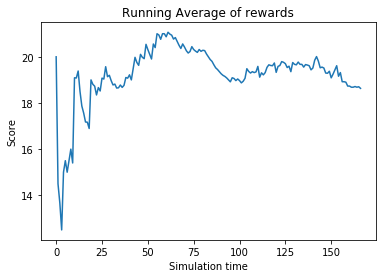

In [26]:
plot_running_avg(np.array(envI.reward_arr))


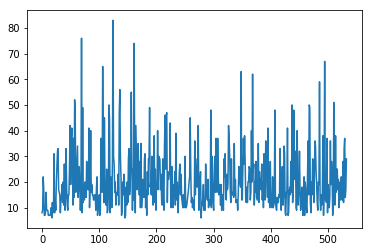

In [8]:
plt.plot(envI.reward_arr)